In [9]:
from datetime import datetime


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import pickle
from tqdm.notebook import tqdm

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import (KMeans, AgglomerativeClustering, DBSCAN)

from sklearn.metrics import silhouette_score

from utils.pipeline import  get_clusters

import warnings
warnings.filterwarnings("ignore")

In [13]:
with open('../config/config.json', 'r') as file:
    config = json.load(file)
    
with open('../config/config_emb_path.json', 'r') as file:
    config_emb = json.load(file)
    
rs = config['random_state']

year_start = 2020
fine_tune = False

for key in config_emb.keys():
    config_emb[key] = config_emb[key].format(year_start)


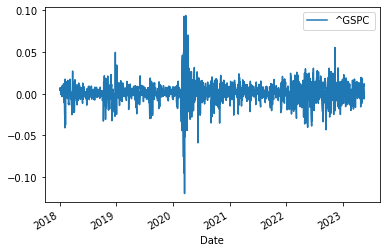

In [14]:

# data loading

df_original = pd.read_csv('../' + config['ticker_data_close'], index_col=0)

df_na = df_original.isna().sum()
thresh = 0.05 * len(df_original)
stocks_to_drop = df_na[df_na > thresh].index.tolist()
df_original = df_original.drop(stocks_to_drop, axis=1)
df_original = df_original.dropna(axis=0)

df_original.index = pd.to_datetime(df_original.index)
df_original_train = df_original[(df_original.index < datetime(year_start, 1, 1)) ]

df = pd.read_csv('../' + config['ticker_data_preprocessed'], index_col=0)
df_pct = df.drop(['sector'], axis=1).T
df_pct.index = pd.to_datetime(df_pct.index)

tickers_list = df_pct.columns.tolist()
df_pct_train = df_pct[(df_pct.index < datetime(year_start, 1, 1)) ]

df_market = pd.read_csv('../' + config['ticker_data_sp500'], index_col=0)
df_market.index = pd.to_datetime(df_market.index)
df_market = df_market.pct_change()
df_market.plot()

df_sectors = pd.read_csv('../' + config['tickers_sectors_path'], index_col=0)
df_sectors = df_sectors.sort_values('ticker')
df_sectors.head()

tickers = df.index.tolist()

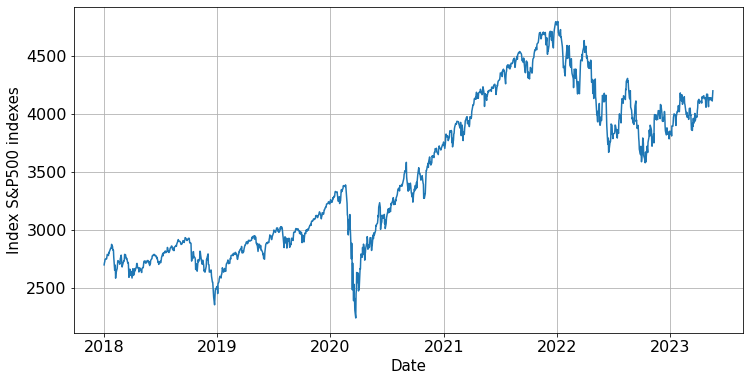

In [15]:
df_market1 = pd.read_csv('../'+config['ticker_data_sp500'], index_col=0)
df_market1.index = pd.to_datetime(df_market1.index)

fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111)
ax.plot(df_market1)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)

ax.set_xlabel('Date', fontsize = 15)
ax.set_ylabel('Index S&P500 indexes', fontsize = 15)
plt.grid()

plt.show()

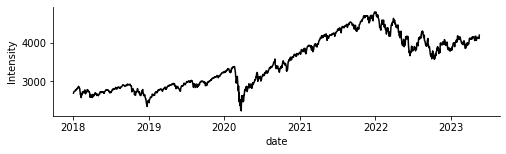

In [16]:
df_market = pd.read_csv('../'+config['ticker_data_sp500'], index_col=0)
df_market.index = pd.to_datetime(df_market.index)

fig = plt.figure(figsize = (8, 2))
ax = fig.add_subplot(111)
ax.plot(df_market, color='black')
#plt.yaxis('off')

ax.set_xlabel('date')
ax.set_ylabel('Intensity')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [17]:
print(', '.join(df_sectors['sector'].unique().tolist()))

Healthcare, Industrials, Consumer Cyclical, Technology, Consumer Defensive, Utilities, Financial, Basic Materials, Real Estate, Energy, Communication Services


# Scatterplots results

In [21]:
def load_data(exp_name):
    df = pd.read_csv(f'data/data/{exp_name}/ticker_data_preprocessed.csv', index_col=0)
    df_pct = df.drop(['sector'], axis=1).T
    df_pct.index = pd.to_datetime(df_pct.index)

    emb_dict = dict()
    top_path = f"data/embeddings/{exp_name}"
    all_files = os.listdir(top_path)

    for emb_path in all_files:
        
        emb_name = emb_path.replace('.csv', '')
        emb_path = top_path + '/' + emb_path
        
        emb_dict[emb_name] = pd.read_csv(emb_path, index_col=0).values
        
    return df, df_pct, emb_dict

def draw_plot(
    features_sectors,
    df_sectors,
    features_methods,
    df_clusters,
):
    plt.figure(figsize=(22, 6))
    plt.subplot(1, 3, 1)
    ax = sns.scatterplot(features_sectors[:, 0], features_sectors[:, 1], hue=df_sectors,
                        palette="tab20b", legend= False)

    plt.xlabel('tsne_axis_1')
    plt.ylabel('tsne_axis_2')
    plt.title('Clusters from Economic Sectors')
    plt.grid()


    plt.subplot(1, 3, 2)
    sns.scatterplot(features_methods[0][:, 0], features_methods[0][:, 1], hue=df_clusters[0]['cluster'],  
                    palette="tab20b", legend=False)
    plt.xlabel('tsne_axis_1')
    plt.ylabel('tsne_axis_2')
    plt.title(f'Clusters from topology PI2 (fitted) model')
    plt.grid()

    plt.subplot(1, 3, 3)
    sns.scatterplot(features_methods[1][:, 0], features_methods[1][:, 1], hue=df_clusters[1]['cluster'],  
                    palette="tab20b", legend=False)
    plt.xlabel('tsne_axis_1')
    plt.ylabel('tsne_axis_2')
    plt.title(f'Clusters from transformer (embedding layer)')
    plt.grid()

    plt.show()
  
def build_embeddings(df_pct, emb_dict, embeddings, n_clusters=11, random_state=42): 
    
    df_clusters = []
    features = [] 
    for emb_name in embeddings:
        embedding_data = emb_dict[emb_name]
        tickers_list = df_pct.columns.tolist()

        clust_params = {'clust_model': KMeans(n_clusters=n_clusters, random_state=random_state),
                        'make_grid':False}

        norm_emb = StandardScaler().fit_transform(embedding_data)
        df_clusters.append(get_clusters(norm_emb, tickers_list, **clust_params))
        features.append(TSNE(n_components=2).fit_transform(norm_emb))
    return features, df_clusters

def draw_scatter_plot(
    exp_name, 
    embeddings=['PersImage_1', 'transformer_embds1'], 
    n_clusters=11
):
    df, df_pct, emb_dict = load_data(exp_name)

    features_sectors = TSNE(n_components=2).fit_transform(df.drop(['sector'], axis=1))
    features_methods, df_clusters = build_embeddings(df_pct, emb_dict, embeddings, n_clusters)
    draw_plot(features_sectors, df['sector'], features_methods, df_clusters,)
   

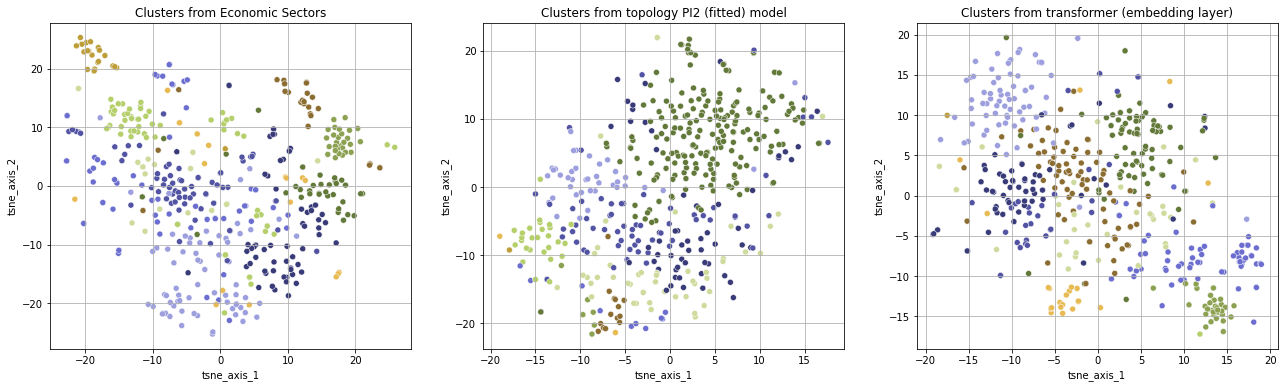

In [22]:
draw_scatter_plot('usa_2018')

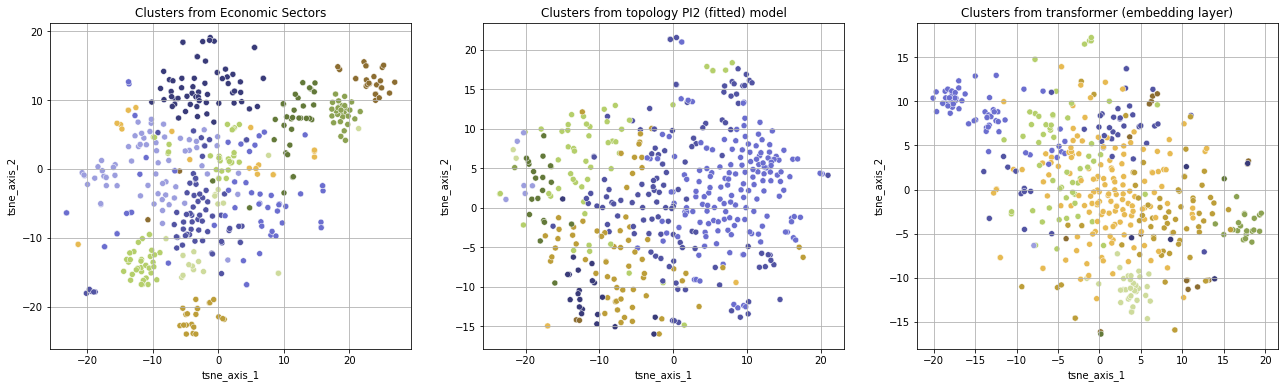

In [23]:
draw_scatter_plot('usa_2015')

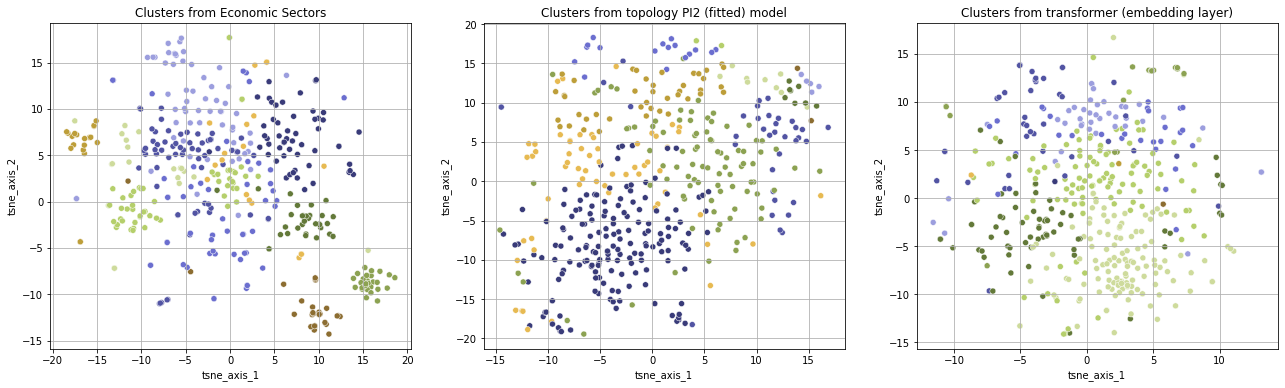

In [24]:
draw_scatter_plot('usa_2012')

In [10]:
exp_name='usa_2018'

df = pd.read_csv(f'data/data/{exp_name}/ticker_data_preprocessed.csv', index_col=0)
df_pct = df.drop(['sector'], axis=1).T
df_pct.index = pd.to_datetime(df_pct.index)

emb_dict = dict()
top_path = f"data/embeddings/{exp_name}"
all_files = os.listdir(top_path)

for emb_path in all_files:
    
    emb_name = emb_path.replace('.csv', '')
    emb_path = top_path + '/' + emb_path
    
    emb_dict[emb_name] = pd.read_csv(emb_path, index_col=0).values

In [11]:
sorted(emb_dict.keys())

['PersImage_1',
 'PersImage_2',
 'PersLandscape_1',
 'PersLandscape_2',
 'autoencoder_conv',
 'autoencoder_lstm',
 'autoencoder_mlp',
 'fastica',
 'pca',
 'table_finance_features',
 'topo_features',
 'transformer_embds1',
 'transformer_embds2',
 'transformer_embds3',
 'transformer_embds4',
 'transformer_embds5',
 'ts2vec',
 'tsfresh',
 'umap']

In [6]:
feats_tsne_sectors = TSNE(n_components=2).fit_transform(df.drop(['sector'], axis=1))
feats_pca_sectors = PCA(n_components=2).fit_transform(df.drop(['sector'], axis=1))

In [12]:
name_1 = 'PersImage_1'
embedding_data = emb_dict[name_1]
tickers_list = df_pct.columns.tolist()

clust_params = {'clust_model': KMeans(n_clusters=config['n_clusters'], random_state=rs),
                'make_grid':False}

# make clustering
norm_emb = StandardScaler().fit_transform(embedding_data)
df_clusters = get_clusters(norm_emb, tickers_list, **clust_params)


feats_tsne_method = TSNE(n_components=2).fit_transform(norm_emb)
feats_pca_method = PCA(n_components=2).fit_transform(norm_emb)

NameError: name 'config' is not defined

In [13]:
name_2 = 'transformer_embds1'
embedding_data2 = emb_dict[name_2]
tickers_list = df_pct.columns.tolist()

clust_params = {'clust_model': KMeans(n_clusters=config['n_clusters'], random_state=rs),
                'make_grid':False}

# make clustering
norm_emb = StandardScaler().fit_transform(embedding_data2)
df_clusters2 = get_clusters(norm_emb, tickers_list, **clust_params)

feats_tsne_method2 = TSNE(n_components=2).fit_transform(norm_emb)
feats_pca_method2 = PCA(n_components=2).fit_transform(norm_emb)

NameError: name 'config' is not defined

NameError: name 'feats_tsne_method' is not defined

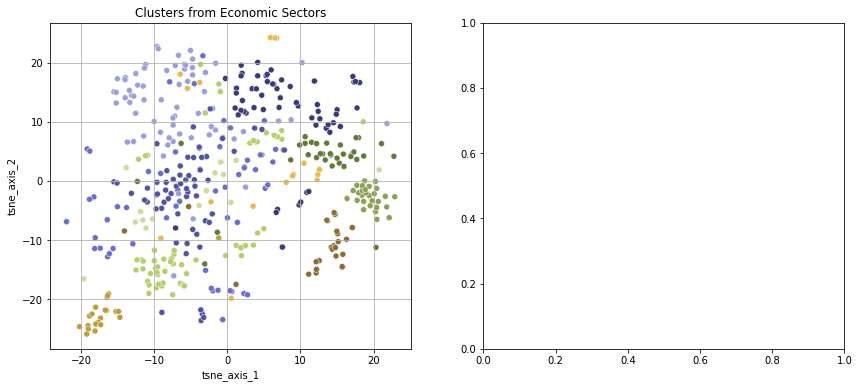

In [14]:
#sns.set_theme(style="ticks", palette="pastel")

plt.figure(figsize=(22, 6))
plt.subplot(1, 3, 1)
ax = sns.scatterplot(feats_tsne_sectors[:, 0], feats_tsne_sectors[:, 1], hue=df['sector'],
                     palette="tab20b", legend= False)

plt.xlabel('tsne_axis_1')
plt.ylabel('tsne_axis_2')
plt.title('Clusters from Economic Sectors')
plt.grid()


plt.subplot(1, 3, 2)
sns.scatterplot(feats_tsne_method[:, 0], feats_tsne_method[:, 1], hue=df_clusters['cluster'],  
                palette="tab20b", legend=False)
plt.xlabel('tsne_axis_1')
plt.ylabel('tsne_axis_2')
plt.title(f'Clusters from topology PI2 (fitted) model')
plt.grid()

plt.subplot(1, 3, 3)
sns.scatterplot(feats_tsne_method2[:, 0], feats_tsne_method2[:, 1], hue=df_clusters2['cluster'],  
                palette="tab20b", legend=False)
plt.xlabel('tsne_axis_1')
plt.ylabel('tsne_axis_2')
plt.title(f'Clusters from transformer (embedding layer)')
plt.grid()

plt.show()

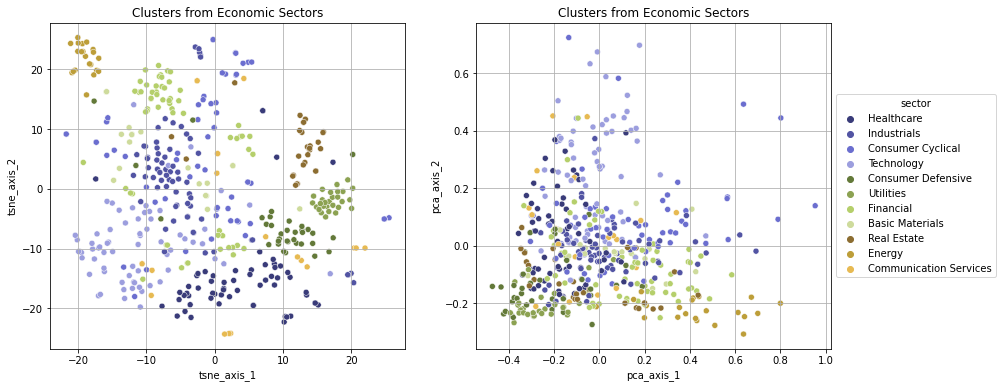

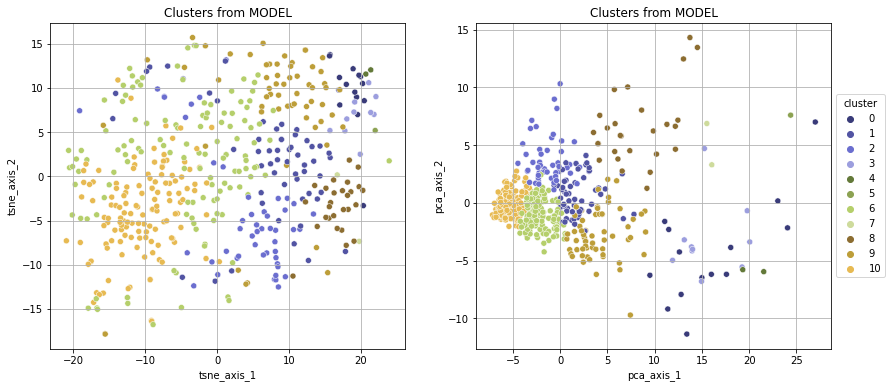

In [27]:
#sns.set_theme(style="ticks", palette="pastel")

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
ax = sns.scatterplot(feats_tsne_sectors[:, 0], feats_tsne_sectors[:, 1], hue=df['sector'],
                     palette="tab20b", legend= False)

plt.xlabel('tsne_axis_1')
plt.ylabel('tsne_axis_2')
plt.title('Clusters from Economic Sectors')
plt.grid()


plt.subplot(1, 2, 2)
ax = sns.scatterplot(feats_pca_sectors[:, 0], feats_pca_sectors[:, 1], hue=df['sector'],  palette="tab20b")
sns.move_legend(ax, "center left", bbox_to_anchor=(1, 0.5))
plt.xlabel('pca_axis_1')
plt.ylabel('pca_axis_2')
plt.title('Clusters from Economic Sectors')
plt.grid()
plt.show()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(feats_tsne_method[:, 0], feats_tsne_method[:, 1], hue=df_clusters['cluster'],  
                palette="tab20b", legend=False)
plt.xlabel('tsne_axis_1')
plt.ylabel('tsne_axis_2')
plt.title('Clusters from MODEL')
plt.grid()


plt.subplot(1, 2, 2)
ax = sns.scatterplot(feats_pca_method[:, 0], feats_pca_method[:, 1], hue=df_clusters['cluster'],  palette="tab20b")
sns.move_legend(ax, "center left", bbox_to_anchor=(1, 0.5))
plt.xlabel('pca_axis_1')
plt.ylabel('pca_axis_2')
plt.title('Clusters from MODEL')
plt.grid()
plt.show()

# heatmap

In [28]:
def get_clusters_heatmap(emb_name):
    embedding_data = emb_dict[emb_name]
    tickers_list = df_pct.columns.tolist()

    clust_params = {'clust_model': KMeans(n_clusters=config['n_clusters'], random_state=rs),
                    'make_grid':False}

    # make clustering
    norm_emb = StandardScaler().fit_transform(embedding_data)
    df_clusters = get_clusters(norm_emb, tickers_list, **clust_params)
    
    return df_clusters

In [29]:
emb_name1 = 'ts2vec'
df_clusters1 = get_clusters_heatmap(emb_name1)

emb_name2 = 'transformer_embds1'
df_clusters2 = get_clusters_heatmap(emb_name2)

emb_name3 = 'takens_mult_PI_2'
df_clusters3 = get_clusters_heatmap(emb_name3)

KeyError: 'takens_mult_PI_2'

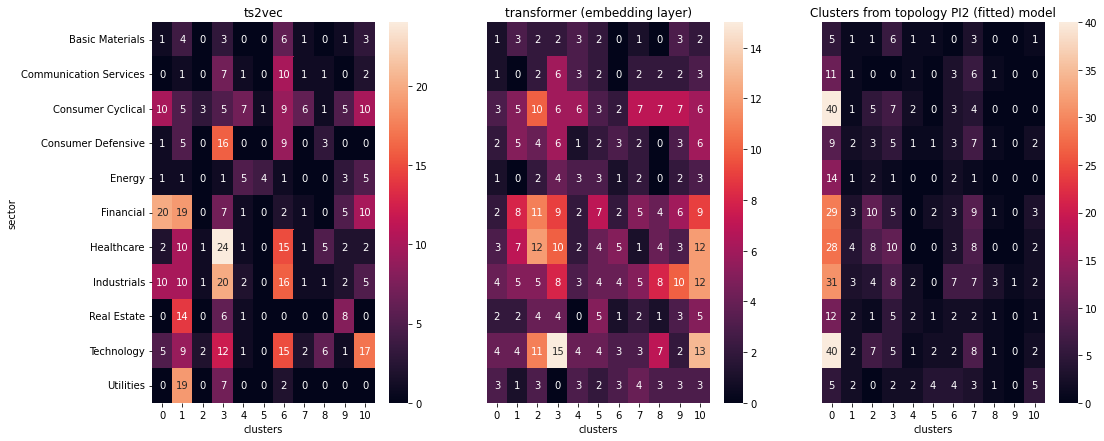

In [ ]:
plt.figure(figsize=(17, 7))

plt.subplot(1, 3, 1)
df_crosstab1 = pd.crosstab(df['sector'], df_clusters1['cluster'].values.flatten())
ax = sns.heatmap(df_crosstab1, annot=True)
plt.title(emb_name1)
plt.xlabel('clusters')

plt.subplot(1, 3, 2)
df_crosstab2 = pd.crosstab(df['sector'], df_clusters2['cluster'].values.flatten())
ax = sns.heatmap(df_crosstab2, annot=True)
ax.get_yaxis ().set_visible ( False )
plt.title('transformer (embedding layer)')
plt.xlabel('clusters')

plt.subplot(1, 3, 3)
df_crosstab3 = pd.crosstab(df['sector'], df_clusters3['cluster'].values.flatten())
ax = sns.heatmap(df_crosstab3, annot=True)
ax.get_yaxis ().set_visible ( False )
plt.title('Clusters from topology PI2 (fitted) model')
plt.xlabel('clusters')

plt.show()

# Plots with portfolios

In [ ]:
df_market = pd.read_csv('../'+config['ticker_data_sp500'], index_col=0)
df_market.index = pd.to_datetime(df_market.index)
df_market = df_market.pct_change()

In [ ]:
with open('../'+config['port_path'].format(2020, False), 'rb') as f:
    dict_port_methods = pickle.load(f)
    
dict_keys = list(dict_port_methods.keys())
for key in dict_keys:
    if '_sigma=0.0005' in key:
        dict_port_methods[key.replace('_sigma=0.0005', '')] = dict_port_methods[key]
        del dict_port_methods[key]

In [ ]:
sorted(dict_port_methods.keys())

['TimeSeriesKMeans',
 'autoencoder_conv',
 'autoencoder_lstm',
 'autoencoder_mlp',
 'fastica',
 'pca',
 'sectors',
 'signal2vec_embds',
 'table_finance_features',
 'takens_mult_BC_0',
 'takens_mult_BC_1',
 'takens_mult_BC_2',
 'takens_mult_PI_0',
 'takens_mult_PI_1',
 'takens_mult_PI_2',
 'takens_mult_PL_1',
 'takens_mult_PL_2',
 'takens_one_BC_0',
 'takens_one_BC_1',
 'takens_one_BC_2',
 'takens_one_PI_0',
 'takens_one_PI_1',
 'takens_one_PI_2',
 'takens_one_PL_1',
 'takens_one_PL_2',
 'tnse',
 'transformer_embds1',
 'transformer_embds2',
 'transformer_embds3',
 'transformer_embds_sum_23',
 'transformer_embds_sum_all',
 'ts2vec',
 'tsfresh',
 'umap']

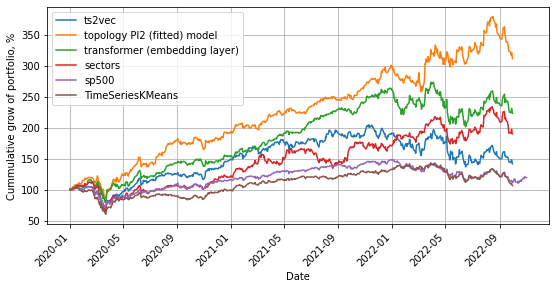

In [ ]:
plt.figure(figsize=(9, 4))

methods = {'ts2vec':dict_port_methods['ts2vec']['KMeans'],
           'topology PI2 (fitted) model':dict_port_methods['takens_mult_PI_2']['KMeans'],
           'transformer (embedding layer)':dict_port_methods['transformer_embds1']['KMeans'],
           'sectors':dict_port_methods['sectors']['sectors'],
           'sp500': df_market[df_market.index > datetime(2020, 1, 1)],
           'TimeSeriesKMeans': dict_port_methods['TimeSeriesKMeans']['TimeSeriesKMeans'],
           }

for method_name, vals in methods.items():
    plt.plot((1+ vals).cumprod() * 100, label=method_name)

plt.xticks(rotation=45, ha='right')
plt.grid()
plt.legend()
plt.xlabel('Date')
plt.ylabel('Cummulative grow of portfolio, %')

plt.show()